In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Define the base input directory where the dataset is stored
base_dir = '/kaggle/input/ua-detrac-dataset'

# List subdirectories (train, val, etc.) instead of all files
for dirname in os.listdir(base_dir):
    dirpath = os.path.join(base_dir, dirname)
    if os.path.isdir(dirpath):
        print(f"Found directory: {dirpath}")


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Found directory: /kaggle/input/ua-detrac-dataset/content


In [2]:
import os
import shutil

# Paths to dataset folders based on the updated structure
train_image_folder = '/kaggle/input/ua-detrac-dataset/content/UA-DETRAC/DETRAC_Upload/images/train'
val_image_folder = '/kaggle/input/ua-detrac-dataset/content/UA-DETRAC/DETRAC_Upload/images/val'
train_label_folder = '/kaggle/input/ua-detrac-dataset/content/UA-DETRAC/DETRAC_Upload/labels/train'
val_label_folder = '/kaggle/input/ua-detrac-dataset/content/UA-DETRAC/DETRAC_Upload/labels/val'

# Output paths
output_train_image_folder = '/kaggle/working/train_images_1s'
output_train_label_folder = '/kaggle/working/train_labels_1s'
output_val_image_folder = '/kaggle/working/val_images_1s'
output_val_label_folder = '/kaggle/working/val_labels_1s'

# Create output directories if they don't exist
os.makedirs(output_train_image_folder, exist_ok=True)
os.makedirs(output_train_label_folder, exist_ok=True)
os.makedirs(output_val_image_folder, exist_ok=True)
os.makedirs(output_val_label_folder, exist_ok=True)

# Frame interval (1 image per second at 15 fps)
frame_interval = 15

def process_images(image_folder, label_folder, output_image_folder, output_label_folder):
    image_count = 0
    
    # Loop over the images and take every nth image (every 15th in this case)
    for idx, image_file in enumerate(sorted(os.listdir(image_folder))):
        if idx % frame_interval == 0:  # Take every 15th frame
            # Get full image and label paths
            image_path = os.path.join(image_folder, image_file)
            label_path = os.path.join(label_folder, image_file.replace('.jpg', '.txt'))  # Assuming labels are in .txt
            
            # Check if corresponding label file exists
            if os.path.exists(label_path):
                # Copy selected image and label to output folders
                shutil.copy(image_path, os.path.join(output_image_folder, image_file))
                shutil.copy(label_path, os.path.join(output_label_folder, os.path.basename(label_path)))
                
            image_count += 1
    
    print(f"Processed {image_count} images from {image_folder}.")

# Process train and val datasets
process_images(train_image_folder, train_label_folder, output_train_image_folder, output_train_label_folder)
process_images(val_image_folder, val_label_folder, output_val_image_folder, output_val_label_folder)

Processed 5587 images from /kaggle/input/ua-detrac-dataset/content/UA-DETRAC/DETRAC_Upload/images/train.
Processed 3756 images from /kaggle/input/ua-detrac-dataset/content/UA-DETRAC/DETRAC_Upload/images/val.


In [3]:
pip install -U albumentations


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.8/225.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.4/291.4 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.17
    Uninstalling albucore-0.0.17:
      Successfully uninstalled albucore-0.0.17
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.17
    Uninstalling albumentations-1.4.17:
      Successfully uninstalled albumentations-1.4.17
Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import albumentations as A

# Parameters for extreme fog with non-uniform intensity
FOG_INTENSITY = 0.9
TRANSPARENCY = 0.9
GRADIENT_START = 0.6
GRADIENT_END = 1.0

def add_varying_fog(image, fog_intensity=FOG_INTENSITY, transparency=TRANSPARENCY, gradient_start=GRADIENT_START, gradient_end=GRADIENT_END):
    """Add a fog effect with varying intensity across the image."""
    h, w = image.shape[:2]
    fog_gradient = np.linspace(fog_intensity, 0, h)
    fog_gradient = np.clip(fog_gradient, gradient_start, gradient_end)
    fog_layer = np.ones_like(image, dtype=np.uint8) * 255
    fogged_image = np.zeros_like(image)
    for y in range(h):
        alpha = float(1 - (transparency * fog_gradient[y]))
        beta = float(transparency * fog_gradient[y])
        fogged_image[y] = cv2.addWeighted(image[y], alpha, fog_layer[y], beta, 0)
    return fogged_image

def add_light_snowfall(image, snow_density=0.0008):
    """Add subtle falling snow particles effect."""
    height, width = image.shape[:2]
    snow_image = image.copy()
    number_of_flakes = int(height * width * snow_density)
    snow_points = np.random.randint(0, width, (number_of_flakes, 2))
    snow_points[:, 1] = np.random.randint(0, height, number_of_flakes)
    flake_sizes = np.random.randint(1, 3, number_of_flakes)
    
    for i in range(number_of_flakes):
        x, y = snow_points[i]
        size = flake_sizes[i]
        snow_color = (255, 255, 255)
        blur_color = (220, 220, 220)
        cv2.circle(snow_image, (x, y), size, snow_color, -1)
        cv2.circle(snow_image, (x, y), size+1, blur_color, 1)
    
    alpha = 0.85
    return cv2.addWeighted(snow_image, alpha, image, 1 - alpha, 0)

def add_snow(image):
    """Add snow effect using Albumentations and additional snowfall."""
    snow_transform = A.Compose([
        A.RandomSnow(
            brightness_coeff=2.4,
            snow_point_lower=0.3,
            snow_point_upper=0.5,
            p=1
        )
    ])
    snowy_image = snow_transform(image=image)['image']
    final_snowy_image = add_light_snowfall(snowy_image, snow_density=0.0008)
    return final_snowy_image

def add_rain(image):
    """Add a rain effect to the image using Albumentations."""
    rain_transform = A.Compose([
        A.RandomRain(
            brightness_coefficient=0.9,
            drop_width=1,
            blur_value=5,
            p=1
        )
    ])
    return rain_transform(image=image)['image']

def apply_augmentation(image, effect):
    """Apply the specified augmentation effect to the image."""
    if effect == 'original':
        return image
    elif effect == 'fog':
        return add_varying_fog(image)
    elif effect == 'rain':
        return add_rain(image)
    elif effect == 'snow':
        return add_snow(image)
    else:
        return image

# Define input and output folders
output_train_image_folder = '/kaggle/working/train_images_1s'
output_train_label_folder = '/kaggle/working/train_labels_1s'
output_val_image_folder = '/kaggle/working/val_images_1s'
output_val_label_folder = '/kaggle/working/val_labels_1s'

# Output paths for augmented images
augmented_train_image_folder = '/kaggle/working/augmented_train_images'
augmented_val_image_folder = '/kaggle/working/augmented_val_images'

# Create output directories if they don't exist
os.makedirs(augmented_train_image_folder, exist_ok=True)
os.makedirs(augmented_val_image_folder, exist_ok=True)

def augment_images(image_folder, output_folder):
    """Process all images in a folder with all weather effects."""
    total_images = len(os.listdir(image_folder))
    for idx, image_file in enumerate(os.listdir(image_folder), 1):
        image_path = os.path.join(image_folder, image_file)
        
        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not read image: {image_path}")
            continue
            
        # Convert to RGB for processing
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply all effects and save
        for effect in ['original', 'fog', 'rain', 'snow']:
            # Apply effect
            augmented_image = apply_augmentation(image_rgb.copy(), effect)
            
            # Convert back to BGR for saving
            augmented_image_bgr = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
            
            # Create new filename
            new_image_name = f"{effect}_{image_file}"
            output_path = os.path.join(output_folder, new_image_name)
            
            # Save the augmented image
            cv2.imwrite(output_path, augmented_image_bgr)
        
        # Print progress
        if idx % 10 == 0:  # Print progress every 10 images
            print(f"Processed {idx}/{total_images} images in {image_folder}")

# Process both train and validation sets
print("Processing training images...")
augment_images(output_train_image_folder, augmented_train_image_folder)

print("\nProcessing validation images...")
augment_images(output_val_image_folder, augmented_val_image_folder)

print("\nAugmentation completed!")

# Print summary of augmented files
train_augmented = len(os.listdir(augmented_train_image_folder))
val_augmented = len(os.listdir(augmented_val_image_folder))

print(f"\nSummary:")
print(f"Total augmented training images: {train_augmented}")
print(f"Total augmented validation images: {val_augmented}")

Processing training images...
Processed 10/5471 images in /kaggle/working/train_images_1s
Processed 20/5471 images in /kaggle/working/train_images_1s
Processed 30/5471 images in /kaggle/working/train_images_1s
Processed 40/5471 images in /kaggle/working/train_images_1s
Processed 50/5471 images in /kaggle/working/train_images_1s
Processed 60/5471 images in /kaggle/working/train_images_1s
Processed 70/5471 images in /kaggle/working/train_images_1s
Processed 80/5471 images in /kaggle/working/train_images_1s
Processed 90/5471 images in /kaggle/working/train_images_1s
Processed 100/5471 images in /kaggle/working/train_images_1s
Processed 110/5471 images in /kaggle/working/train_images_1s
Processed 120/5471 images in /kaggle/working/train_images_1s
Processed 130/5471 images in /kaggle/working/train_images_1s
Processed 140/5471 images in /kaggle/working/train_images_1s
Processed 150/5471 images in /kaggle/working/train_images_1s
Processed 160/5471 images in /kaggle/working/train_images_1s
Pro

In [5]:
def count_images(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

# Count the images
num_train_images = count_images(augmented_train_image_folder)
num_val_images = count_images(augmented_val_image_folder)

print(f'Number of augmented training images: {num_train_images}')
print(f'Number of augmented validation images: {num_val_images}')

Number of augmented training images: 21884
Number of augmented validation images: 14984


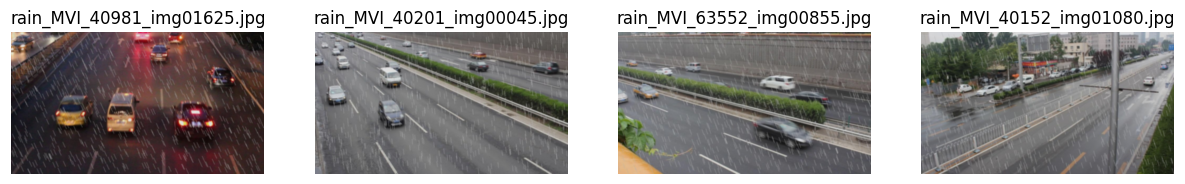

In [8]:
def show_augmented_sample(image_folder, num_samples=5):
    samples = random.sample(os.listdir(image_folder), num_samples)
    fig, ax = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, sample in enumerate(samples):
        img = cv2.imread(os.path.join(image_folder, sample))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        ax[i].imshow(img_rgb)
        ax[i].axis('off')
        ax[i].set_title(sample)

# Show a few samples from augmented train images
show_augmented_sample(augmented_train_image_folder, num_samples=4)

In [11]:
import os

def prepare_labels_for_augmented_images():
    """
    Create corresponding label files for augmented images by copying original labels.
    Only creates labels if corresponding augmented images exist.
    """
    effects = ['original', 'fog', 'rain', 'snow']
    
    # Create new directories for augmented labels
    new_train_labels = os.path.join(DATASET_PATH, 'augmented_train_labels')
    new_val_labels = os.path.join(DATASET_PATH, 'augmented_val_labels')
    
    # Create directories if they don't exist
    os.makedirs(new_train_labels, exist_ok=True)
    os.makedirs(new_val_labels, exist_ok=True)
    
    # Process training labels
    for label_file in os.listdir(TRAIN_LABELS):
        if not label_file.endswith('.txt'):
            continue
            
        base_name = label_file[:-4]  # Remove .txt
        
        # Check if corresponding original image exists
        original_image_name = f"original_{base_name}.jpg"  # or .png depending on your image format
        if not os.path.exists(os.path.join(TRAIN_IMAGES, original_image_name)):
            continue
            
        # Read original label content
        with open(os.path.join(TRAIN_LABELS, label_file), 'r') as f:
            label_content = f.read()
        
        # Create labels for each augmented version
        for effect in effects:
            # Check if augmented image exists
            aug_image_name = f"{effect}_{base_name}.jpg"  # or .png
            if os.path.exists(os.path.join(TRAIN_IMAGES, aug_image_name)):
                aug_label_path = os.path.join(new_train_labels, f"{effect}_{base_name}.txt")
                with open(aug_label_path, 'w') as f:
                    f.write(label_content)

    # Similar process for validation labels
    for label_file in os.listdir(VAL_LABELS):
        if not label_file.endswith('.txt'):
            continue
            
        base_name = label_file[:-4]  # Remove .txt
        
        # Check if corresponding original image exists
        original_image_name = f"original_{base_name}.jpg"  # or .png
        if not os.path.exists(os.path.join(VAL_IMAGES, original_image_name)):
            continue
            
        # Read original label content
        with open(os.path.join(VAL_LABELS, label_file), 'r') as f:
            label_content = f.read()
        
        # Create labels for each augmented version
        for effect in effects:
            # Check if augmented image exists
            aug_image_name = f"{effect}_{base_name}.jpg"  # or .png
            if os.path.exists(os.path.join(VAL_IMAGES, aug_image_name)):
                aug_label_path = os.path.join(new_val_labels, f"{effect}_{base_name}.txt")
                with open(aug_label_path, 'w') as f:
                    f.write(label_content)

    print(f"Augmented labels created in {new_train_labels} and {new_val_labels}")

In [12]:
print("Preparing labels for augmented images...")
prepare_labels_for_augmented_images()

Preparing labels for augmented images...
Augmented labels created in /kaggle/working/augmented_train_labels and /kaggle/working/augmented_val_labels


In [13]:
def check_label_counts():
    """
    Check and compare the number of files in original and new label directories.
    Also verifies if all augmented labels have corresponding images.
    """
    # Get counts for training data
    new_train_labels_path = os.path.join(DATASET_PATH, 'augmented_train_labels')
    train_labels_count = len([f for f in os.listdir(new_train_labels_path) if f.endswith('.txt')])
    train_images_count = len([f for f in os.listdir(TRAIN_IMAGES) if f.endswith('.jpg') or f.endswith('.png')])
    
    # Get counts for validation data
    new_val_labels_path = os.path.join(DATASET_PATH, 'augmented_val_labels')
    val_labels_count = len([f for f in os.listdir(new_val_labels_path) if f.endswith('.txt')])
    val_images_count = len([f for f in os.listdir(VAL_IMAGES) if f.endswith('.jpg') or f.endswith('.png')])
    
    print("\n=== Label and Image Counts ===")
    print(f"Training:")
    print(f"- Number of augmented label files: {train_labels_count}")
    print(f"- Number of augmented images: {train_images_count}")
    print(f"- Labels per original image: {train_labels_count/4 if train_labels_count > 0 else 0:.0f}")
    
    print(f"\nValidation:")
    print(f"- Number of augmented label files: {val_labels_count}")
    print(f"- Number of augmented images: {val_images_count}")
    print(f"- Labels per original image: {val_labels_count/4 if val_labels_count > 0 else 0:.0f}")
    
    # Verify matching between labels and images
    print("\n=== Verification ===")
    print("Checking if all labels have corresponding images...")
    
    # Check training files
    missing_train = 0
    for label_file in os.listdir(new_train_labels_path):
        if label_file.endswith('.txt'):
            image_file = label_file[:-4] + '.jpg'  # or .png depending on your format
            if not os.path.exists(os.path.join(TRAIN_IMAGES, image_file)):
                missing_train += 1
                
    # Check validation files
    missing_val = 0
    for label_file in os.listdir(new_val_labels_path):
        if label_file.endswith('.txt'):
            image_file = label_file[:-4] + '.jpg'  # or .png depending on your format
            if not os.path.exists(os.path.join(VAL_IMAGES, image_file)):
                missing_val += 1
    
    print(f"Training files without corresponding images: {missing_train}")
    print(f"Validation files without corresponding images: {missing_val}")

# Run the check
check_label_counts()


=== Label and Image Counts ===
Training:
- Number of augmented label files: 21884
- Number of augmented images: 21884
- Labels per original image: 5471

Validation:
- Number of augmented label files: 14984
- Number of augmented images: 14984
- Labels per original image: 3746

=== Verification ===
Checking if all labels have corresponding images...
Training files without corresponding images: 0
Validation files without corresponding images: 0


In [9]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.7/877.7 kB 15.2 MB/s eta 0:00:00a 0:00:01


In [10]:
from ultralytics import YOLO
import yaml
import os
from pathlib import Path
import shutil
import torch 

# Define paths
DATASET_PATH = '/kaggle/working'
TRAIN_IMAGES = '/kaggle/working/augmented_train_images'
VAL_IMAGES = '/kaggle/working/augmented_val_images'
TRAIN_LABELS = '/kaggle/working/train_labels_1s'
VAL_LABELS = '/kaggle/working/val_labels_1s'
CHECKPOINT_DIR = '/kaggle/working/UA-DETRAC-weather/checkpoints'

# UA-DETRAC vehicle classes
CLASSES = {
    0: 'others',
    1: 'car',
    2: 'van',
    3: 'bus' 
}


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [14]:
import os
import shutil
import yaml

# Define paths
DATASET_PATH = '/kaggle/working'
TRAIN_IMAGES = '/kaggle/working/augmented_train_images'
VAL_IMAGES = '/kaggle/working/augmented_val_images'
new_train_labels = os.path.join(DATASET_PATH, 'augmented_train_labels')
new_val_labels = os.path.join(DATASET_PATH, 'augmented_val_labels')

# Define target directories
images_path = os.path.join(DATASET_PATH, 'images')
labels_path = os.path.join(DATASET_PATH, 'labels')

# Remove existing directories and files if they exist
if os.path.exists(images_path):
    shutil.rmtree(images_path)
if os.path.exists(labels_path):
    shutil.rmtree(labels_path)

# Delete existing dataset.yaml if it exists
config_path = os.path.join(DATASET_PATH, 'dataset.yaml')
if os.path.exists(config_path):
    os.remove(config_path)

# Create new directories for YOLO's expected structure
os.makedirs(images_path)
os.makedirs(labels_path)

In [15]:
new_train_folder_path = os.path.join(images_path, 'train')
shutil.move(TRAIN_IMAGES, new_train_folder_path)

'/kaggle/working/images/train'

In [16]:
new_val_folder_path = os.path.join(images_path, 'val')
shutil.move(VAL_IMAGES, new_val_folder_path)

new_train_label_path = os.path.join(labels_path, 'train')
shutil.move(new_train_labels, new_train_label_path)

new_val_label_path = os.path.join(labels_path, 'val')
shutil.move(new_val_labels, new_val_label_path  )

'/kaggle/working/labels/val'

In [17]:
# Create a new dataset YAML configuration
dataset_config = {
    'path': DATASET_PATH,
    'train': 'images/train',
    'val': 'images/val',
    'names': CLASSES,
    'nc': len(CLASSES)
}

# Write the new configuration to dataset.yaml
with open(config_path, 'w') as f:
    yaml.dump(dataset_config, f)

print("New dataset.yaml created at:", config_path)

New dataset.yaml created at: /kaggle/working/dataset.yaml


In [20]:
def train_yolo(resume_from=None):
    """
    Initialize and train YOLOv8x model with built-in checkpointing
    """
    # Load a pretrained YOLOv8x model
    model = YOLO('yolov8x.pt')
    
    # Training arguments
    args = dict(
        data=config_path,
        epochs=50,
        imgsz=640,
        batch=16,
        device=0,  # Use GPU
        patience=10,  # Early stopping patience
        save=True,  # Save results
        save_period=5,  # Save checkpoint every 5 epochs
        project='UA-DETRAC-weather',
        name='yolov8x_weather_aug',
        exist_ok=True,
        pretrained=True,
        optimizer='Adam',
        lr0=0.001,
        lrf=0.01,
        momentum=0.937,
        weight_decay=0.0005,
        warmup_epochs=3.0,
        warmup_momentum=0.8,
        warmup_bias_lr=0.1,
        box=7.5,
        cls=0.5,
        dfl=1.5,
        pose=12.0,
        kobj=1.0,
        label_smoothing=0.0,
        nbs=64,
        overlap_mask=True,
        mask_ratio=4,
        dropout=0.0,
        val=True
    )
    
    # If resuming from checkpoint
    if resume_from:
        if os.path.exists(resume_from):
            args['resume'] = resume_from
        else:
            print(f"Warning: Checkpoint {resume_from} not found. Starting fresh training.")
    
    # Train the model
    results = model.train(**args)
    return results, model

In [21]:
def validate_model(model_path):
    """
    Validate the trained model on the validation set
    """
    model = YOLO(model_path)
    metrics = model.val(data=config_path, split='val')
    return metrics

In [ ]:
if __name__ == "__main__":  # This ensures the code only runs if the script is run directly, not when imported
    
    print("Starting YOLOv8x training...")
    
    # This calls your training function which returns both the training results and the trained model
    results, model = train_yolo()
    
    # Constructs the path where YOLO will save the best model weights
    # DATASET_PATH/UA-DETRAC-weather/yolov8x_weather_aug/weights/best.pt
    model_path = os.path.join(DATASET_PATH, 'UA-DETRAC-weather/yolov8x_weather_aug/weights/best.pt')
    print(f"Training completed. Best model saved at: {model_path}")
    
    print("\nValidating final model...")
    # Runs validation on the best model and gets the performance metrics
    val_metrics = validate_model(model_path)

    # Prints the overall model performance:
    print("\nTraining Results:")
    print(f"Best mAP50: {val_metrics.map50:.3f}")  # Mean Average Precision at 50% IoU threshold
    print(f"Best mAP50-95: {val_metrics.map:.3f}") # Mean Average Precision across different IoU thresholds

    # Prints performance metrics for each weather class:
    print("\nPer-class Performance:")
    for i in range(4):  # Loops through the 4 weather classes
        class_name = ['cloudy', 'night', 'rainy', 'sunny'][i]
        print(f"{class_name}:")
        # Get class-specific results using the class_result method
        p, r, ap50, ap = val_metrics.class_result(i)
        print(f"  Precision: {p:.3f}")
        print(f"  Recall: {r:.3f}")
        print(f"  AP50: {ap50:.3f}")

Starting YOLOv8x training...
Ultralytics 8.3.24 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/kaggle/working/dataset.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=0, workers=8, project=UA-DETRAC-weather, name=yolov8x_weather_aug, exist_ok=True, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sav

train: Scanning /kaggle/working/labels/train... 21884 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21884/21884 [00:19<00:00, 1096.58it/s]


train: New cache created: /kaggle/working/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/labels/val... 14984 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14984/14984 [00:14<00:00, 1037.22it/s]


val: New cache created: /kaggle/working/labels/val.cache
Plotting labels to UA-DETRAC-weather/yolov8x_weather_aug/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to UA-DETRAC-weather/yolov8x_weather_aug
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      16.6G     0.9228     0.6541     0.9947        139        640: 100%|██████████| 1368/1368 [36:50<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 469/469 [04:49<00:00,  1.62it/s]


                   all      14984     182400      0.598      0.534      0.547      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      13.8G     0.8673     0.5659       0.98        162        640: 100%|██████████| 1368/1368 [32:33<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 469/469 [04:47<00:00,  1.63it/s]


                   all      14984     182400      0.704       0.51      0.557      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      13.4G     0.8348     0.5265     0.9686        104        640: 100%|██████████| 1368/1368 [32:25<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 469/469 [04:46<00:00,  1.64it/s]


                   all      14984     182400      0.651      0.546      0.604      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      13.4G     0.8036     0.4917     0.9547        184        640: 100%|██████████| 1368/1368 [32:20<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 469/469 [04:45<00:00,  1.64it/s]


                   all      14984     182400       0.66      0.532      0.548      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      13.4G     0.7871     0.4729       0.95        177        640: 100%|██████████| 1368/1368 [32:19<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 469/469 [04:45<00:00,  1.64it/s]


                   all      14984     182400      0.686      0.579      0.625      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      13.4G       0.77     0.4556     0.9438        193        640: 100%|██████████| 1368/1368 [32:15<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 469/469 [04:45<00:00,  1.64it/s]


                   all      14984     182400       0.71      0.512      0.588      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      13.4G     0.7618     0.4448     0.9395        166        640: 100%|██████████| 1368/1368 [32:21<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 469/469 [04:46<00:00,  1.64it/s]


                   all      14984     182400      0.689      0.597      0.627      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      13.4G     0.7532     0.4374     0.9364        141        640: 100%|██████████| 1368/1368 [32:28<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 469/469 [04:46<00:00,  1.64it/s]


                   all      14984     182400      0.733      0.534      0.606      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      13.3G     0.7474     0.4313     0.9342        150        640: 100%|██████████| 1368/1368 [32:31<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 469/469 [04:47<00:00,  1.63it/s]


                   all      14984     182400      0.723      0.526      0.579      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      13.4G     0.7398      0.423     0.9311        180        640: 100%|██████████| 1368/1368 [32:32<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 469/469 [04:50<00:00,  1.61it/s]


                   all      14984     182400      0.693      0.556      0.611      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      13.4G     0.7351     0.4181     0.9303        127        640: 100%|██████████| 1368/1368 [32:31<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 469/469 [04:49<00:00,  1.62it/s]


                   all      14984     182400      0.693      0.528      0.597      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      13.4G     0.7297     0.4113     0.9264        159        640: 100%|██████████| 1368/1368 [32:30<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 469/469 [04:53<00:00,  1.60it/s]


                   all      14984     182400      0.632      0.531      0.569      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      13.4G     0.7262     0.4074     0.9244        201        640: 100%|██████████| 1368/1368 [32:32<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 469/469 [04:53<00:00,  1.60it/s]


                   all      14984     182400      0.662      0.549      0.598      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      13.4G     0.7229     0.4056     0.9246        130        640: 100%|██████████| 1368/1368 [32:32<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 469/469 [04:52<00:00,  1.60it/s]


                   all      14984     182400      0.613      0.609      0.635      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      13.4G     0.7328     0.4077     0.9258        233        640:   1%|▏         | 19/1368 [00:26<31:56,  1.42s/it]

In [23]:
pip install -U ipywidgets

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.9 MB/s eta 0:00:0000:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
big